### Importing Libraries

In [359]:
#Generic Libraries
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
from PIL import Image
import pandas as pd
import numpy as np

#Apache Spark Libraries
from pyspark.sql import SparkSession, Row
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql import functions as F
from pyspark.sql import types as T


# sklearn Libraries
import sklearn
from sklearn.model_selection import train_test_split

In [360]:
spark = SparkSession.builder.appName('AcidSoils').getOrCreate()
source = gpd.read_file("data/GTK_ASsoil_obs.csv")
source.head(4)

,POINT_X,POINT_Y,CLASS,geometry
0,441468.7125,7184281.005,ASS,None
1,441852.3101,7186002.327,ASS,None
2,442236.5012,7185249.359,ASS,None
3,420520.3581,7208257.978,ASS,None


In [361]:
geom = gpd.points_from_xy(source.POINT_X.astype("float"), source.POINT_Y.astype("float"))
points = gpd.GeoDataFrame(source.CLASS, crs="EPSG:3067", geometry=geom).to_crs("WGS84")
points.head(4)

,CLASS,geometry
0,ASS,POINT (25.76894 64.77799)
1,ASS,POINT (25.77630 64.79350)
2,ASS,POINT (25.78469 64.78681)
3,ASS,POINT (25.31512 64.98873)


In [362]:
points["x"] = points.geometry.x
points["y"] = points.geometry.y

points.head(4)

,CLASS,geometry,x,y
0,ASS,POINT (25.76894 64.77799),25.768938,64.777988
1,ASS,POINT (25.77630 64.79350),25.776304,64.793496
2,ASS,POINT (25.78469 64.78681),25.784691,64.786808
3,ASS,POINT (25.31512 64.98873),25.315115,64.988732


In [363]:
df = spark.createDataFrame(points)
df.show(4,truncate=False)

+-----+---------------------------+------------------+-----------------+
|CLASS|geometry                   |x                 |y                |
+-----+---------------------------+------------------+-----------------+
|ASS  |{105553164528128, false, 2}|25.768937832725747|64.77798766173387|
|ASS  |{105553164528224, false, 2}|25.77630416654702 |64.79349633623737|
|ASS  |{105553164528032, false, 2}|25.784691167397362|64.7868078298281 |
|ASS  |{105553164527936, false, 2}|25.315115332474953|64.98873249710591|
+-----+---------------------------+------------------+-----------------+
only showing top 4 rows



In [364]:
df= (df.
    select(
        "geometry","x","y",
    (F.col("CLASS") == "ASS").astype("int").alias("class"),
    )
)
df.show(4,truncate=False)

+---------------------------+------------------+-----------------+-----+
|geometry                   |x                 |y                |class|
+---------------------------+------------------+-----------------+-----+
|{105553164528128, false, 2}|25.768937832725747|64.77798766173387|1    |
|{105553164528224, false, 2}|25.77630416654702 |64.79349633623737|1    |
|{105553164528032, false, 2}|25.784691167397362|64.7868078298281 |1    |
|{105553164527936, false, 2}|25.315115332474953|64.98873249710591|1    |
+---------------------------+------------------+-----------------+-----+
only showing top 4 rows



In [365]:
df.groupby('class').count().show()

+-----+-----+
|class|count|
+-----+-----+
|    1| 3490|
|    0| 2334|
+-----+-----+



## Add point ID

In [366]:
TILE_SIZE = 256

@F.udf(returnType=T.ArrayType(T.IntegerType()))
def project_pixel(lon, lat, zoom):
    # lon, lat = p.geometry.x, p.geometry.y
    
    siny = np.sin(lat * np.pi / 180)
    siny = min(max(siny, -0.9999), 0.9999)
    
    x = TILE_SIZE * (0.5 + lon / 360)
    y = TILE_SIZE * (0.5 - np.log((1 + siny) / (1 - siny)) / (4 * np.pi))
    
    scale = 2**zoom

    tx = x * scale // TILE_SIZE
    ty = y * scale // TILE_SIZE

    px = x * scale % TILE_SIZE // 1
    py = y * scale % TILE_SIZE // 1

    return [int(px), int(py)]
        
@F.udf(returnType=T.ArrayType(T.IntegerType()))
def project_tile(lon, lat, zoom):
    
    siny = np.sin(lat * np.pi / 180)
    siny = min(max(siny, -0.9999), 0.9999)
    
    x = TILE_SIZE * (0.5 + lon / 360)
    y = TILE_SIZE * (0.5 - np.log((1 + siny) / (1 - siny)) / (4 * np.pi))
    
    scale = 2**zoom

    tx = x * scale // TILE_SIZE
    ty = y * scale // TILE_SIZE

    px = x * scale % TILE_SIZE // 1
    py = y * scale % TILE_SIZE // 1

    return [int(zoom), int(tx), int(ty)]

In [367]:
#for zoom = 8
df_points8 = (
    df
    .withColumn("pixel8", project_pixel(df.x, df.y, F.lit(8)))
    .withColumn("tile8", project_tile(df.x, df.y,F.lit(8)))
    .withColumn("point_id", F.monotonically_increasing_id())
    .drop("x", "y", "geometry")
    
)
df_points8.show(4)

+-----+---------+------------+--------+
|class|   pixel8|       tile8|point_id|
+-----+---------+------------+--------+
|    1|[83, 254]|[8, 146, 66]|       0|
|    1|[84, 247]|[8, 146, 66]|       1|
|    1|[85, 250]|[8, 146, 66]|       2|
|    1| [0, 163]|[8, 146, 66]|       3|
+-----+---------+------------+--------+
only showing top 4 rows



In [368]:
#for zoom = 9
df_points9 = (
    df
    .withColumn("pixel9", project_pixel(df.x, df.y, F.lit(9)))
    .withColumn("tile9", project_tile(df.x, df.y,F.lit(9)))
    .withColumn("point_id", F.monotonically_increasing_id())
    .drop("x", "y", "geometry")
)
#df_points9.show(4)

In [369]:
#for zoom = 10
df_points10 = (
    df

    .withColumn("pixel10", project_pixel(df.x, df.y, F.lit(10)))
    .withColumn("tile10", project_tile(df.x, df.y,F.lit(10)))
    .withColumn("point_id", F.monotonically_increasing_id())
    .drop("x", "y", "geometry")
    
)

#df_points10.show(4)


## Combine output class with pixel coordinates

In [201]:
TILES_BASIC = "/Users/tamiratatsemegiorgis/project/MapTilesViewer/basic/{z}/{x}/{y}.png"
TILES_HILLSHADE ="/Users/tamiratatsemegiorgis/project/TILES_hillshade/{z}/{x}/{y}.png"

@F.udf(returnType=T.ArrayType(T.ArrayType(T.LongType())))
def load_image_data(tile, pixel_data, tiles):
    """
    tiles: folder with tiles
    """
    (z, tx, ty) = tile
    fname = tiles.format(z=z, x=tx, y=ty)
    im = Image.open(fname)
    arr_img= np.array(im)

    data = []
    for i, j, pid in pixel_data:
        if arr_img.shape[-1] == 3:
            # color image
            r, g, b = arr_img[i, j] # 3 dim array, ?
            data.append([int(r), int(g), int(b), pid])
        else:
            # grayscale image
            gray, alpha = arr_img[i, j]
            data.append([int(gray), pid])
    
    return data


### For zoom level 8

In [370]:
df_basic_raw8 = (
    df_points8
    .select(
        "point_id", "pixel8", "tile8",
    )
    .withColumn("pixel_i8", F.col("pixel8")[0])
    .withColumn("pixel_j8", F.col("pixel8")[1])
    .withColumn("pixel_data8", F.array(F.col("pixel_i8"), F.col("pixel_j8"), F.col("point_id")))
    
    # processing
    .groupby("tile8")
    .agg(
        F.collect_list("pixel_data8").alias("pixel_data_list8"),
    )
    .withColumn("data_basic8", load_image_data(F.col("tile8"), F.col("pixel_data_list8"),F.lit(TILES_BASIC)))
    
    .select(F.explode("data_basic8").alias("data"))
    .select(
        F.col("data")[0].alias("basic_r8"),F.col("data")[1].alias("basic_g8"),
        F.col("data")[2].alias("basic_b8"),F.col("data")[3].alias("point_id"),     
    )
    
    # put back points class
    .join(
        df_points8.select("CLASS", "point_id"),     on="point_id",
    )     
)
df_basic_raw8.show(2)

+--------+--------+--------+--------+-----+
|point_id|basic_r8|basic_g8|basic_b8|CLASS|
+--------+--------+--------+--------+-----+
|      26|      61|      77|      48|    1|
|      29|      87|      96|      65|    1|
+--------+--------+--------+--------+-----+
only showing top 2 rows



 ## For zoom level 9

In [371]:
df_basic_raw9 = (
    df_points9
    .select(
        "point_id", "pixel9", "tile9"
    )
    .withColumn("pixel_i9", F.col("pixel9")[0])
    .withColumn("pixel_j9", F.col("pixel9")[1])
    .withColumn("pixel_data9", F.array(F.col("pixel_i9"), F.col("pixel_j9"), F.col("point_id")))

    # processing
    .groupby("tile9")
    .agg(
        F.collect_list("pixel_data9").alias("pixel_data_list9"),
    )
    .withColumn("data_basic9", load_image_data(F.col("tile9"), F.col("pixel_data_list9"),F.lit(TILES_BASIC)))
    .select(F.explode("data_basic9").alias("data"))
    .select(
        F.col("data")[0].alias("basic_r9"), F.col("data")[1].alias("basic_g9"),
        F.col("data")[2].alias("basic_b9"), F.col("data")[3].alias("point_id"),
        )
     # put back points class
    .join(
        df_points8.select("CLASS", "point_id"),     on="point_id",
    )  
    )
df_basic_raw9.show(4)

+--------+--------+--------+--------+-----+
|point_id|basic_r9|basic_g9|basic_b9|CLASS|
+--------+--------+--------+--------+-----+
|      26|     118|     111|      95|    1|
|      29|     107|     102|      82|    1|
|     474|      53|      75|      39|    1|
|      65|      86|     108|      70|    1|
+--------+--------+--------+--------+-----+
only showing top 4 rows



 ## For zoom level 10

In [372]:
df_basic_raw10 = (
    df_points10
    .select(
        "point_id", 
        "pixel10", 
        "tile10",
        "class",
    )
    .withColumn("pixel_i10", F.col("pixel10")[0])
    .withColumn("pixel_j10", F.col("pixel10")[1])
    .withColumn("pixel_data10", F.array(F.col("pixel_i10"), F.col("pixel_j10"), F.col("point_id")))

    # processing
    .groupby("tile10")
    .agg(
        F.collect_list("pixel_data10").alias("pixel_data_list10"),
    )
    .withColumn("data_basic10", load_image_data(F.col("tile10"), F.col("pixel_data_list10"),
                                               F.lit(TILES_BASIC)))
    .select(F.explode("data_basic10").alias("data"))
    .select(
        F.col("data")[0].alias("basic_r10"),
        F.col("data")[1].alias("basic_g10"),
        F.col("data")[2].alias("basic_b10"),
        F.col("data")[3].alias("point_id"),
        
    )
     # put back points class
    .join(
        df_points8.select("CLASS", "point_id"),     on="point_id",
    )  
)
df_basic_raw10.show(4)

+--------+---------+---------+---------+-----+
|point_id|basic_r10|basic_g10|basic_b10|CLASS|
+--------+---------+---------+---------+-----+
|      26|       51|       69|       31|    1|
|      29|       79|      100|       59|    1|
|     474|       76|      106|       72|    1|
|      65|       70|       94|       60|    1|
+--------+---------+---------+---------+-----+
only showing top 4 rows



In [374]:
#df1=df_basic_raw10.filter(df_basic_raw10.point_id ==459 )
#df1.show()

In [375]:
 # Join pyspark datasets for zoom 8,9 and 10
sp_df_data_raw_8_9_10 = (
    df_basic_raw8.drop("CLASS")
    .join(df_basic_raw9.drop("CLASS"), on="point_id")
     .join(df_basic_raw10, on="point_id")
)
sp_df_data_raw_8_9_10.show(4)

+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+-----+
|point_id|basic_r8|basic_g8|basic_b8|basic_r9|basic_g9|basic_b9|basic_r10|basic_g10|basic_b10|CLASS|
+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+-----+
|       0|     100|     114|      78|     107|     101|      75|      106|       92|       66|    1|
|       1|     115|     122|      88|      81|     102|      69|       70|       81|       47|    1|
|       2|      99|     103|      70|      85|      95|      61|       80|       87|       56|    1|
|       3|      81|      97|      61|     104|     114|      90|       60|       79|       51|    1|
+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+-----+
only showing top 4 rows



In [376]:
#check the CLASS column
sp_df_data_raw_8_9_10.groupby('CLASS').count().show()

+-----+-----+
|CLASS|count|
+-----+-----+
|    1| 3490|
|    0| 2334|
+-----+-----+



In [377]:
sp_df_data_raw_8_9_10.printSchema()

root
 |-- point_id: long (nullable = true)
 |-- basic_r8: long (nullable = true)
 |-- basic_g8: long (nullable = true)
 |-- basic_b8: long (nullable = true)
 |-- basic_r9: long (nullable = true)
 |-- basic_g9: long (nullable = true)
 |-- basic_b9: long (nullable = true)
 |-- basic_r10: long (nullable = true)
 |-- basic_g10: long (nullable = true)
 |-- basic_b10: long (nullable = true)
 |-- CLASS: integer (nullable = true)



## Model building and Testing using  Using Sk-learn

In [378]:
#convert the pyspark dataframe to pandas dataframe
df_data_raw_8_9_10=sp_df_data_raw_8_9_10.toPandas()
df_data_raw_8_9_10.set_index('point_id')

,basic_r8,basic_g8,basic_b8,basic_r9,basic_g9,basic_b9,basic_r10,basic_g10,basic_b10,CLASS
point_id,,,,,,,,,,
0,100,114,78,107,101,75,106,92,66,1
1,115,122,88,81,102,69,70,81,47,1
2,99,103,70,85,95,61,80,87,56,1
3,81,97,61,104,114,90,60,79,51,1
4,131,139,102,157,165,126,56,56,30,1
...,...,...,...,...,...,...,...,...,...,...
60129542867,108,115,81,121,98,67,143,122,93,1
60129542868,95,111,72,109,118,87,87,98,64,0
60129542869,95,111,72,109,118,87,87,98,64,0


In [379]:
#df_data_raw_8_9_10.describe()

In [381]:
#df_data_raw_8_9_10.groupby("CLASS").size()


In [382]:
# create independent featur X and label column y
X= df_data_raw_8_9_10.iloc[:,1:10].values
y=df_data_raw_8_9_10.iloc[:,-1].values
X

array([[100, 114,  78, ..., 106,  92,  66],
       [115, 122,  88, ...,  70,  81,  47],
       [ 99, 103,  70, ...,  80,  87,  56],
       ...,
       [ 95, 111,  72, ...,  87,  98,  64],
       [156, 130,  97, ..., 178, 182, 145],
       [  7,  37,  48, ...,   9,  38,  52]])

In [383]:
#split train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33,random_state=0)
X_train.shape

(3902, 9)

## Train a model with  RandomForestClassifier

In [387]:
#using Rendomiz search with cv = 5
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform 
from scipy.stats import randint

rfc = RandomForestClassifier(criterion = 'entropy', class_weight = 'balanced')
param_dist = {"max_depth" : randint(1,10),
              "n_estimators" :randint(2,1000),
              "max_features" :randint(1,20)}
n_iter_search = 50
start=time.time()

random_search = RandomizedSearchCV(rfc, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, 
                                   n_jobs=-1, verbose=2, scoring='roc_auc')
search = random_search.fit(X_train, y_train)
print(f'Time: {time.time() - start}')

print("Summary of Results")
print(" ")
print("Best score: {}".format(search.best_score_))
print(" ")
print("Best parameters: {}".format(search.best_params_))
print(" ")
print("Best parameters: {}".format(search.scorer_))



Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/tamiratatsemegiorgis/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
120 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/tamiratatsemegiorgis/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/tamiratatsemegiorgis/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/Users/tamiratatsemegiorgis/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 10

Time: 56.92983675003052
Summary of Results
 
Best score: 0.5703988827661761
 
Best parameters: {'max_depth': 8, 'max_features': 5, 'n_estimators': 406}
 
Best parameters: make_scorer(roc_auc_score, needs_threshold=True)


In [390]:
search.score(X_test, y_test)

0.5690874582583549

In [396]:
y_pred = search.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)

print("The Accuracy for Test Set is {}".format(test_acc*100))


The Accuracy for Test Set is 54.31841831425598


Text(0.5, 26.5, 'Predicted Values')

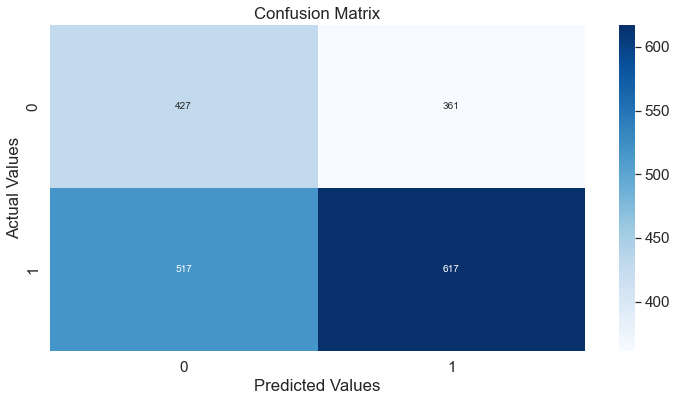

In [397]:
cm=confusion_matrix(y_test,y_pred)
plt.figure(figsize=(12,6))
plt.title("Confusion Matrix")
sns.heatmap(cm, annot=True,fmt="d", cmap='Blues')
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")

## LogisticRegression

In [398]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge

In [424]:
std_slc = StandardScaler()
logistic_Reg = LogisticRegression(solver='liblinear',)

pipe = Pipeline(steps=[('std_slc', std_slc),
                           ('logistic_Reg', logistic_Reg)])

C = np.logspace(-4, 4, 50)
penalty = ['l1', 'l2']

parameters = dict(logistic_Reg__C=C,
                    logistic_Reg__penalty=penalty)


clf_GS = GridSearchCV(pipe, parameters,cv=5, n_jobs=2)
clf_GS.fit(X_train, y_train)

print('Best Penalty:', clf_GS.best_estimator_.get_params()['logistic_Reg__penalty'])
print('Best C:', clf_GS.best_estimator_.get_params()['logistic_Reg__C'])
print(); print(clf_GS.best_estimator_.get_params()['logistic_Reg'])

Best Penalty: l1
Best C: 0.040949150623804234

LogisticRegression(C=0.040949150623804234, penalty='l1', solver='liblinear')


In [429]:
print("Test set score: {:.2f}".format(clf_GS.score(X_test, y_test)))
print("Train set score: {}".format(clf_GS.score(X_train, y_train)))

Test set score: 0.59
Train set score: 0.6035366478728857


Text(0.5, 26.5, 'Predicted Values')

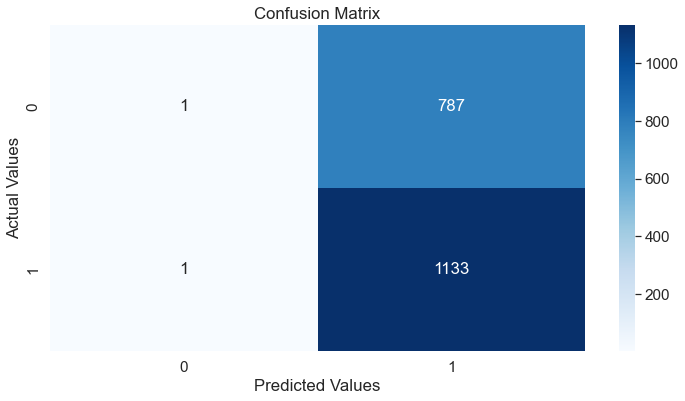

In [430]:
cm=confusion_matrix(y_test,y_pred)
plt.figure(figsize=(12,6))
plt.title("Confusion Matrix")
sns.heatmap(cm, annot=True,fmt="d", cmap='Blues')
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")


# Using scikit-elm model

In [418]:
import skelm
from skelm import ELMRegressor

In [419]:
model = ELMRegressor(n_neurons=10, ufunc='tanh')

y_pred = model.fit(X, y).predict(X)
rmse = np.mean((y_pred - y)**2)**0.5

print("RMSE scikit-elm: {:.2f}".format(rmse))

RMSE scikit-elm: 0.49
